In [68]:
%load_ext autoreload
%autoreload 2

from __future__ import print_function
%matplotlib inline
import cv2
import os
from skimage import io, transform
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import torch
import torchvision
from torchvision import transforms, datasets, utils as vutils
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
# https://www.researchgate.net/publication/353370951_Towards_Lifespan_Automation_for_Caenorhabditis_elegans_Based_on_Deep_Learning_Analysing_Convolutional_and_Recurrent_Neural_Networks_for_Dead_or_Live_Classification

from data_utils import LstmLoader
from model import Resnet18Pretrained
from model import ResnetLSTM


data_path = "data/training"

data_loader = LstmLoader(data_path)


# Settings

learning_rate = 0.1

epochs = 100


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [52]:
sample = torch.randn(3, 3, 244, 244).to(device)

# Pass a few data to see how it looks
model = ResnetLSTM().to(device)
a = model(sample)
print(a)

sample, label = data_loader[0][0].to(device), data_loader[0][1]
out = model(sample)
print(out)

print(label)

tensor([[0.5091]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.5123]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(1)


In [53]:

test_len = int(len(data_loader) * 0.15)
train_len = len(data_loader) - test_len

print(f"Total Data: {len(data_loader)}")
print(f"Test split: {test_len}")
print(f"Train split: {train_len}")

test_data, train_data = torch.utils.data.random_split(data_loader, (test_len, train_len))

# train_data = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
# test_data = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=0)


Total Data: 2144
Test split: 321
Train split: 1823


In [45]:
# train_data = DataLoader(train_data, batch_size=None, shuffle=True, num_workers=0)
# test_data = DataLoader(test_data, batch_size=None, shuffle=True, num_workers=0)

In [46]:
alive = 0
dead = 0

for i in train_data:
    seq, label = i
    if int(label) == 1:
        alive += 1
    elif int(label) == 0:
        dead += 1
        
print(dead, alive)

908 915


In [47]:
def test_model(model2, data):
    correct = 0
    incorrect = 0
    dead_correct = 0
    dead_incorrect = 0
    alive_correct = 0
    alive_incorrect = 0
    
    with torch.no_grad():
        for series, label in data:
            series = series.to(device)
            real_class = int(label)
#             real_class = int(torch.argmax(label))
            
            output = model2(series)
            if output > 0.5:
                pred_class = 1
            elif output < 0.5:
                pred_class = 0

#             print(output, pred_class, real_class)
            if pred_class == real_class:
                correct += 1
                if pred_class == 0:
                    dead_correct += 1
                elif pred_class == 1:
                    alive_correct += 1
                    
            else:
                incorrect += 1
                if pred_class == 0:
                    dead_incorrect += 1
                elif pred_class == 1:
                    alive_incorrect += 1
    
    print(alive_correct, alive_incorrect)
    
    overall_accuracy = correct / len(data)
    alive_accuracy = alive_correct / (alive_correct + alive_incorrect) if alive_correct else 0
    dead_accuracy = dead_correct / (dead_correct + dead_incorrect) if dead_correct else 0
    
#     return (correct, incorrect, len(data))
    return round(overall_accuracy, 4), round(alive_accuracy, 4), round(dead_accuracy, 4)

test_model(model, test_data)

0 0


(0.5109, 0, 0.5109)

In [54]:
# Setup Learning Params

criterion = nn.BCELoss()

# optimizer = optim.SGD(model.parameters(), lr=0.01)
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))


# Training Loop
dead = 0
alive = 0

# Class:
#  0: Dead
#  1: Alive

loss_totals = []
test_totals = []
        
for epoch in range(epochs):
    loss_total = 0
    for series, label in train_data:
        model.zero_grad()
        
        series = series.to(device)
        label = label.to(device)
#         label = label.view(1,2)
        
        output = model(series).squeeze()
#         print(output, label)
        loss = criterion(output, label.float())
        loss_total += loss
#         print(output, label, loss)
        loss.backward()
        optimizer.step()
        
    
    
    test_accuracy, a_accuracy, d_accuracy = test_model(model, test_data)
    
    print(f"Epoch {epoch}/{epochs} - Test Accuracy: {test_accuracy} - A&D: {a_accuracy}, {d_accuracy} - Loss: {loss_total/len(train_data)}")
    
    loss_totals.append(loss_total/len(train_data))
    test_totals.append(test_accuracy)
        
        
        

138 0
Epoch 0/100 - Test Accuracy: 0.9502 - A&D: 1.0, 0.9126 - Loss: 0.2826448678970337
143 0
Epoch 1/100 - Test Accuracy: 0.9657 - A&D: 1.0, 0.9382 - Loss: 0.1604517698287964
144 0
Epoch 2/100 - Test Accuracy: 0.9688 - A&D: 1.0, 0.9435 - Loss: 0.14952358603477478
146 0
Epoch 3/100 - Test Accuracy: 0.9751 - A&D: 1.0, 0.9543 - Loss: 0.11192696541547775
144 2
Epoch 4/100 - Test Accuracy: 0.9626 - A&D: 0.9863, 0.9429 - Loss: 0.09723486006259918
148 0
Epoch 5/100 - Test Accuracy: 0.9813 - A&D: 1.0, 0.9653 - Loss: 0.0834372267127037
116 2
Epoch 6/100 - Test Accuracy: 0.8754 - A&D: 0.9831, 0.8128 - Loss: 0.058544691652059555
149 1
Epoch 7/100 - Test Accuracy: 0.9813 - A&D: 0.9933, 0.9708 - Loss: 0.0681101456284523
148 0
Epoch 8/100 - Test Accuracy: 0.9813 - A&D: 1.0, 0.9653 - Loss: 0.055228091776371
149 1
Epoch 9/100 - Test Accuracy: 0.9813 - A&D: 0.9933, 0.9708 - Loss: 0.04451083391904831
149 0
Epoch 10/100 - Test Accuracy: 0.9844 - A&D: 1.0, 0.9709 - Loss: 0.040675703436136246


KeyboardInterrupt: 

In [116]:
# Save Weights
# torch.save(model.state_dict(), "weights/weights1.pt"); print("weights saved")

model = ResnetLSTM().to(device)
model = model.load_state_dict


In [70]:
validation_path = "data/validation"
validation_data = LstmLoader(validation_path)

validation_accuracy = test_model(model, validation_data)

288 4


In [71]:
print(f"Overall Validation Accuracy: {validation_accuracy[0]}, Alive Accuracy: {validation_accuracy[1]}, Dead Acuracy: {validation_accuracy[2]}")

Overall Validation Accuracy: 0.9749, Alive Accuracy: 0.9863, Dead Acuracy: 0.9641


Real Label, Predicted Label:
Dead, Alive


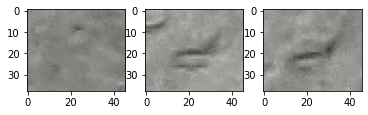

In [160]:
def show_sample(data, index, model=model):
    series, label = data[index]
    label = int(label)
    
    if label == 1:
        real = "Alive"
    elif label == 0:
        real = "Dead"
    
    raw_series, _ = data.__getitem__(index, raw=True)
    
    pred_label = model(series.to(device))
    if pred_label > 0.5:
        pred = "Alive"
    elif pred_label < 0.5:
        pred = "dead"
        
    return raw_series, real, pred
    

# model(validation_data[0][0].to(device))

f, axarr = plt.subplots(1,3)

sample_series, real, pred = show_sample(validation_data, 584)
axarr[0].imshow(sample_series[0])
axarr[1].imshow(sample_series[1])
axarr[2].imshow(sample_series[2])
# print(f"Pred: {}")
print(f"Real Label, Predicted Label:")
print(f"{real}, {pred}")

In [112]:
alive = 0
dead = 0

for i in validation_data:
    seq, label = i
    if int(label) == 1:
        alive += 1
    elif int(label) == 0:
        dead += 1
        
print(dead, alive)

299 299


In [143]:
incorrect = []
for i, item in enumerate(validation_data):
    series, label = item 
    pred_label = model(series.to(device))
    
    if label == 1:
        real = "Alive"
    elif label == 0:
        real = "Dead"
    
    if pred_label > 0.5:
        pred = "Alive"
    elif pred_label < 0.5:
        pred = "Dead"
        
    if pred == real:
        pass
    else:
        incorrect.append(i)
    
    

In [144]:
incorrect

[0, 3, 11, 34, 56, 68, 150, 169, 233, 283, 288, 466, 497, 575, 584]